In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as mvn, norm, multivariate_t as mvt, t, pearsonr, expon
import seaborn as sns
from os.path import join as pjoin

import matplotlib

font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True

In [59]:
SAVE_DIR = (
    "/Users/andrewjones/Documents/princeton_webpage/andrewcharlesjones.github.io/assets"
)

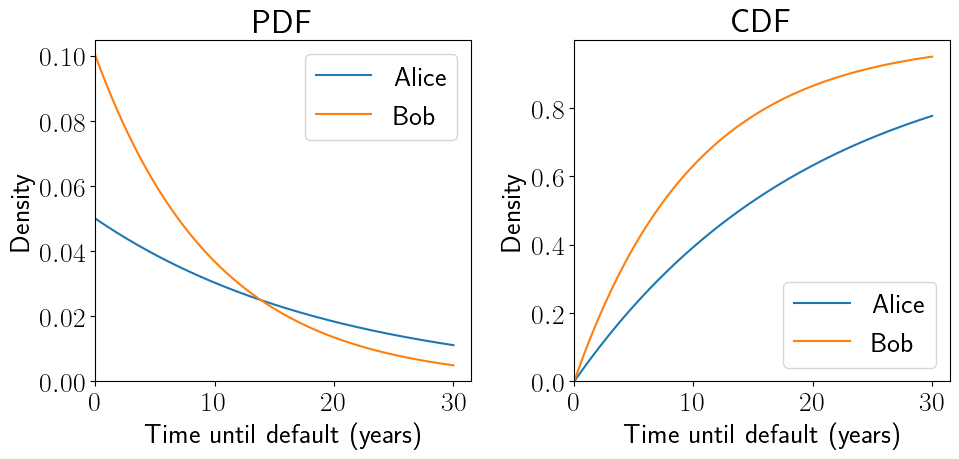

In [215]:
plt.figure(figsize=(10, 5))

alice_scale = 20
bob_scale = 10
rho = 0.7

xs = np.linspace(0, 30, 1_000)

plt.subplot(121)
plt.plot(xs, expon.pdf(xs, scale=alice_scale), label="Alice")
plt.plot(xs, expon.pdf(xs, scale=bob_scale), label="Bob")

plt.xlabel("Time until default (years)")
plt.ylabel("Density")
plt.legend()
plt.title("PDF")
plt.ylim([0, plt.gca().get_ylim()[1]])
plt.xlim([0, plt.gca().get_xlim()[1]])

plt.subplot(122)
plt.plot(xs, expon.cdf(xs, scale=alice_scale), label="Alice")
plt.plot(xs, expon.cdf(xs, scale=bob_scale), label="Bob")

plt.xlabel("Time until default (years)")
plt.ylabel("Density")
plt.legend()
plt.title("CDF")
plt.ylim([0, plt.gca().get_ylim()[1]])
plt.xlim([0, plt.gca().get_xlim()[1]])
plt.tight_layout()
plt.savefig(pjoin(SAVE_DIR, "time_until_default_hist.png"))
plt.show()

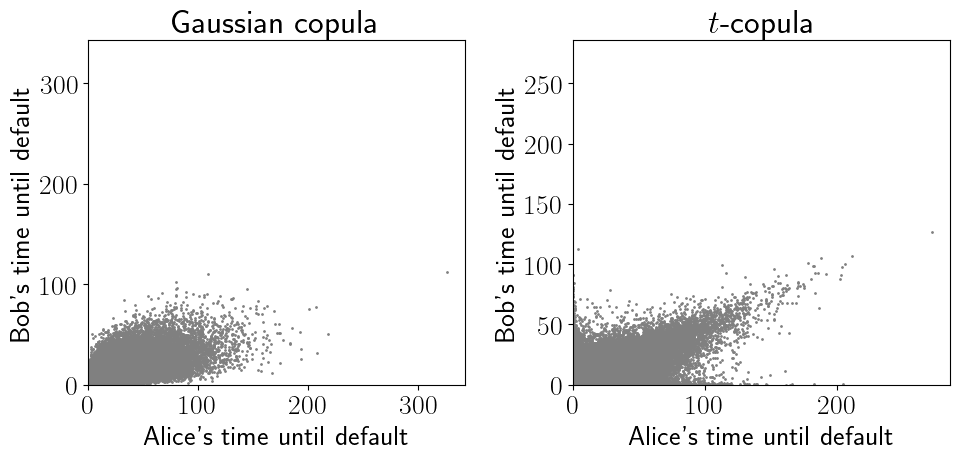

In [216]:
Gs = mvn.rvs(mean=np.zeros(2), cov=np.array([[1, rho], [rho, 1]]), size=int(1e5))
Us = norm.cdf(Gs)
Ts_gaussian = np.stack(
    [
        expon.ppf(Us[:, 0], scale=alice_scale),
        expon.ppf(Us[:, 1], scale=bob_scale),
    ],
    axis=1
)
        

Gs = mvt.rvs(loc=np.zeros(2), shape=np.array([[1, rho], [rho, 1]]), size=int(1e5), df=2)
Us = t.cdf(Gs, df=2)
Ts_tdist = np.stack(
    [
        expon.ppf(Us[:, 0], scale=alice_scale),
        expon.ppf(Us[:, 1], scale=bob_scale),
    ],
    axis=1
)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(Ts_gaussian[:, 0], Ts_gaussian[:, 1], s=1, color="gray")
plt.xlabel("Alice's time until default")
plt.ylabel("Bob's time until default")
plt.title("Gaussian copula")
plt.ylim([0, plt.gca().get_xlim()[1]])
plt.xlim([0, plt.gca().get_xlim()[1]])


plt.subplot(122)
plt.scatter(Ts_tdist[:, 0], Ts_tdist[:, 1], s=1, color="gray")
plt.xlabel("Alice's time until default")
plt.ylabel("Bob's time until default")
plt.title(r"$t$-copula")
plt.ylim([0, plt.gca().get_xlim()[1]])
plt.xlim([0, plt.gca().get_xlim()[1]])
plt.tight_layout()
plt.savefig(pjoin(SAVE_DIR, "tud_copula_sims.png"))
plt.show()

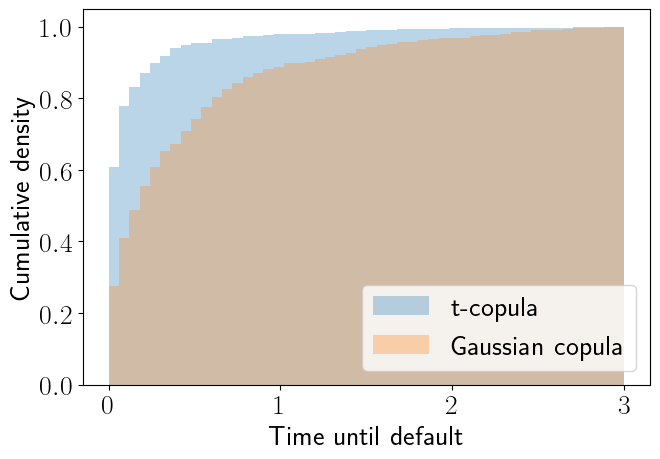

In [217]:
plt.figure(figsize=(7, 5))
plt.hist(Ts_tdist[Ts_tdist[:, 0] < 1e-1][:, 1], cumulative=True, alpha=0.3, bins=50, range=[0, 3], density=True, label="t-copula")
plt.hist(Ts_gaussian[Ts_gaussian[:, 0] < 1e-1][:, 1], cumulative=True, alpha=0.3, bins=50, range=[0, 3], density=True, label="Gaussian copula")
plt.xlabel("Time until default")
plt.ylabel("Cumulative density")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(pjoin(SAVE_DIR, "conditional_cdf_tud.png"))
plt.show()

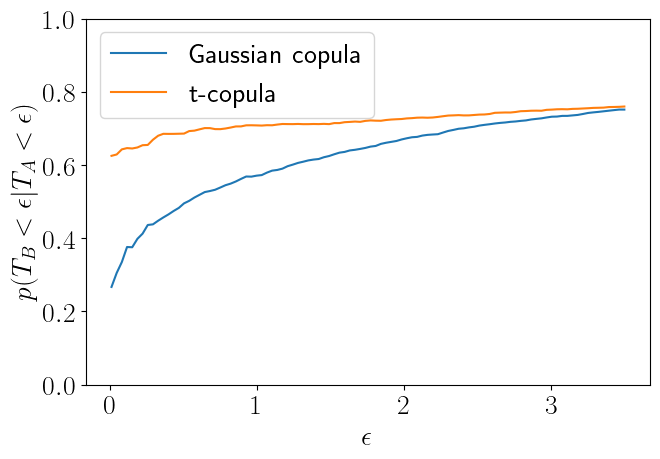

In [223]:
thresholds = np.linspace(1e-2, 3.5, 100)
n_repeats = 10

ps_gaussian = np.zeros((n_repeats, len(thresholds)))
ps_tdist = np.zeros((n_repeats, len(thresholds)))
for ii in range(n_repeats):
    for jj, thresh in enumerate(thresholds):
        Y_subset = Ts_gaussian[Ts_gaussian[:, 0] < thresh]
        ps_gaussian[ii, jj] = np.mean(Y_subset[:, 1] < thresh)
        Y_subset = Ts_tdist[Ts_tdist[:, 0] < thresh]
        ps_tdist[ii, jj] = np.mean(Y_subset[:, 1] < thresh)

plt.figure(figsize=(7, 5))
plt.plot(thresholds, ps_gaussian.mean(0), label="Gaussian copula")
plt.plot(thresholds, ps_tdist.mean(0), label="t-copula")
plt.ylim(0, 1)
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$p(T_B < \epsilon | T_A < \epsilon)$")
plt.legend()
plt.tight_layout()
plt.savefig(pjoin(SAVE_DIR, "tail_dependence_epsilon.png"))
plt.show()